In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble  import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import random

from sklearn import metrics
from collections import Counter
import argparse
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import collections
import re

In [2]:
def other(x):
    if ((x=='exchanges')|(x=='finance')|(x=='games')|(x=='gambling')|(x=='high-risk')): 
        return x 
    else: 
        return 'other'

In [3]:
df = pd.read_csv('../SC-Dapp-scraping/data/dapps_source_code_parsed_open_source_2021-01-08.csv')
df = df[df.SC_full!='\n']
df.drop('Unnamed: 0', axis=1, inplace=True)
df.category = df.category.apply(other)
df.comments.fillna('empty', inplace=True)

In [4]:
def contract_name_extract(data):
    #extract contract name
    contract_name = re.findall('[\n\r].*Contract|contract\s*([^\n\r]*)', data)
    if len(contract_name)>1:
        contract_name_string = ' '.join(contract_name)
        contract_name_string = re.sub(r'[^\w\s]','', contract_name_string)
    elif len(contract_name)==1:
        contract_name_string = contract_name[0]
    elif len(contract_name)==0:
        contract_name_string = 'no_contracts'
    else:
        contract_name_string = contract_name
    return(contract_name_string)

def function_name_extract(data):
    #extract function names and join to one string
    function_name = re.findall('[\n\r].*function\s*([^\n\r\(]*)', data)
    function_name_string = ' '.join(function_name)
    function_name_string = re.sub(r'[^\w\s]','', function_name_string)
    return(function_name_string)

def interface_name_extract(data):
    #extract function names and join to one string
    function_name = re.findall('[\n\r].*Interface|interface\s*([^\n\r\(]*)', data)
    function_name_string = ' '.join(function_name)
    function_name_string = re.sub(r'[^\w\s]','', function_name_string)
    return(function_name_string)


def event_name_extract(data):
    #extract function names and join to one string
    function_name = re.findall('[\n\r].*event\s*([^\n\r\(]*)', data)
    function_name_string = ' '.join(function_name)
    function_name_string = re.sub(r'[^\w\s]','', function_name_string)
    return(function_name_string)

def library_name_extract(data):
    #extract function names and join to one string
    function_name = re.findall('[\n\r].*library\s*([^\n\r\(]*)', data)
    function_name_string = ' '.join(function_name)
    function_name_string = re.sub(r'[^\w\s]','', function_name_string)
    return(function_name_string)

In [5]:
df['contracts_names'] = df.SC_no_comments.apply(contract_name_extract)
df['funcs_names']     = df.SC_no_comments.apply(function_name_extract)
df['int_names']       = df.SC_no_comments.apply(interface_name_extract)
df['eve_names']       = df.SC_no_comments.apply(event_name_extract)
df['lib_names']       = df.SC_no_comments.apply(library_name_extract)
df['structs']         = df['contracts_names'] + df['funcs_names'] + df['int_names'] + df['eve_names'] + df['lib_names']

In [6]:
RS     = 42
SPLITS = 3

In [7]:
X = df.drop('category', axis=1)
y = df.category

In [8]:
y.value_counts()

exchanges    470
finance      317
games        272
other        238
gambling      71
high-risk     60
Name: category, dtype: int64

In [9]:
print(f'There are {df.shape[0]} source codes from {df.slug.nunique()} dapps')

There are 1428 source codes from 473 dapps


In [10]:
X, X_test, y, y_test  = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RS)

In [11]:
print(f'X_train shape {X.shape}')
print(f'X_test shape {X_test.shape}')

X_train shape (1142, 18)
X_test shape (286, 18)


In [12]:
y_test.value_counts()

exchanges    94
finance      64
games        54
other        48
gambling     14
high-risk    12
Name: category, dtype: int64

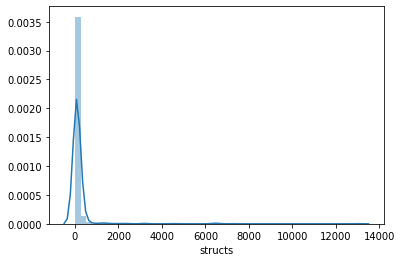

In [13]:
length_SC = X.structs.apply(lambda x: len(x.split()))
sns.distplot(length_SC)

### Ridge Regression

In [14]:
kf  = StratifiedKFold(n_splits=SPLITS, random_state=RS, shuffle=True)

In [15]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 10200, 200)

# use best C

C_parameter = [1]
FEATURES    = [6900]

In [16]:
names = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [17]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['structs'], X.iloc[val_index]['structs']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, solver='sag', random_state=RS)
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 6900 C:1 AUC ROC: 0.936 ###  AUC PRC: 0.738


In [18]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.985
aucroc_finance      0.953
aucroc_gambling     0.878
aucroc_games        0.939
aucroc_high-risk    0.925
dtype: float64

In [19]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.979
aucprc_finance      0.881
aucprc_gambling     0.452
aucprc_games        0.843
aucprc_high-risk    0.536
dtype: float64

In [20]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.983,0.945,0.843,0.935,0.917,0.976,0.868,0.441,0.852,0.597
1,0.985,0.948,0.882,0.945,0.921,0.978,0.869,0.468,0.836,0.439
2,0.987,0.965,0.910,0.936,0.936,0.984,0.905,0.447,0.842,0.572


In [21]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['structs'])
train_word_features  = word_vectorizer.transform(X['structs'])
test_word_features   = word_vectorizer.transform(X_test['structs'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    classifier    = LogisticRegression(C=c_p, 
                                    solver='sag', 
                                    random_state=RS)
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [22]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.988,0.963,0.883,0.957,0.971,0.984,0.906,0.462,0.87,0.735


In [23]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.952
dtype: float64

In [24]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.791
dtype: float64

### Lasso Regression

In [25]:
c = 0
C_parameter = np.arange(0.1, 1.1, 0.1) 
FEATURES    = np.arange(500, 10200, 200)

# use best C

C_parameter = [1]
FEATURES    = [6900]

In [26]:
names  = [f'aucroc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names2 = [f'aucprc_{i}' for i in ['exchanges', 'finance', 'gambling', 'games', 'high-risk']]
names.extend(names2)

In [27]:
for FEATURE in FEATURES:    
    for c_p in C_parameter:  
        metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
        for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURE)

                X_train, X_val      = X.iloc[train_index]['structs'], X.iloc[val_index]['structs']
                y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                word_vectorizer.fit(X_train)
                train_word_features = word_vectorizer.transform(X_train)
                val_word_features   = word_vectorizer.transform(X_val)

                le = LabelBinarizer()
                le.fit(y_train)

                y_train = le.transform(y_train)
                y_val   = le.transform(y_val)

                assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()
                for i, cl in enumerate(le.classes_[le.classes_!='other']):
                    classifier    = LogisticRegression(C=c_p, 
                                                       solver='liblinear', 
                                                       random_state=RS, 
                                                       penalty='l1')
                    classifier.fit(train_word_features, y_train[:,i])
                    probs         = classifier.predict_proba(val_word_features)[:,1]
                    auc_roc_class = roc_auc_score(y_val[:,i], probs)
                    auc_pr_class  = average_precision_score(y_val[:,i], probs)

                    metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                    metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)  


        print(f"# Features: {FEATURE} C:{c_p} AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

# Features: 6900 C:1 AUC ROC: 0.855 ###  AUC PRC: 0.58


In [28]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.937
aucroc_finance      0.890
aucroc_gambling     0.747
aucroc_games        0.888
aucroc_high-risk    0.811
dtype: float64

In [29]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.920
aucprc_finance      0.748
aucprc_gambling     0.288
aucprc_games        0.654
aucprc_high-risk    0.289
dtype: float64

In [30]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.922,0.854,0.745,0.887,0.876,0.901,0.691,0.376,0.656,0.412
1,0.932,0.897,0.798,0.903,0.768,0.920,0.774,0.386,0.674,0.138
2,0.956,0.919,0.697,0.875,0.790,0.940,0.780,0.103,0.631,0.316


In [31]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['structs'])
train_word_features  = word_vectorizer.transform(X['structs'])
test_word_features   = word_vectorizer.transform(X_test['structs'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    classifier = LogisticRegression(C=c_p, 
                                    solver='liblinear', 
                                    random_state=RS, 
                                    penalty='l1')
    classifier.fit(train_word_features, y_train[:,i])
    probs      = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   
    

In [32]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.981,0.919,0.803,0.913,0.874,0.973,0.791,0.395,0.73,0.573


In [33]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.898
dtype: float64

In [34]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.692
dtype: float64

### Random Forest

In [35]:
for FEATURE in FEATURES:
    metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
    for c, (train_index, val_index) in enumerate(kf.split(X, y)):

            X_train, X_val      = X.iloc[train_index]['structs'], X.iloc[val_index]['structs']
            y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
            word_vectorizer     = TfidfVectorizer(
                        sublinear_tf  = True,
                        strip_accents = 'unicode',
                        analyzer      = 'word',
                        token_pattern = r'\w{1,}',
                        ngram_range   = (1, 1),
                        max_features  = FEATURE)
            word_vectorizer.fit(X_train)
            train_word_features = word_vectorizer.transform(X_train)
            val_word_features   = word_vectorizer.transform(X_val)

            le = LabelBinarizer()
            le.fit(y_train)

            y_train = le.transform(y_train)
            y_val   = le.transform(y_val)


            classifier = RandomForestClassifier(n_estimators=600, 
                                                         max_depth=None, 
                                                         max_features='auto',
                                                         min_samples_split=2, 
                                                         verbose = True, 
                                                         n_jobs=20, 
                                                         random_state=RS)
            classifier.fit(train_word_features, y_train)
            probs = classifier.predict_proba(val_word_features)

            assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all()        
            for i, cl in enumerate(le.classes_[le.classes_!='other']):
                auc_roc_class = roc_auc_score(y_val[:,i], probs[i][:,1])
                auc_pr_class  = average_precision_score(y_val[:,i], probs[i][:,1])

                metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

    print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    2.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.5s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed: 

AUC ROC: 0.933 ###  AUC PRC: 0.749


[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.5s finished


In [36]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.971,0.953,0.897,0.951,0.959,0.967,0.878,0.474,0.879,0.693
1,0.979,0.937,0.858,0.923,0.920,0.975,0.859,0.461,0.788,0.600
2,0.985,0.964,0.844,0.935,0.920,0.981,0.887,0.343,0.848,0.598


In [37]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(
                    sublinear_tf  = True,
                    strip_accents = 'unicode',
                    analyzer      = 'word',
                    token_pattern = r'\w{1,}',
                    ngram_range   = (1, 1),
                    max_features  = FEATURES[0])
word_vectorizer.fit(X['structs'])
train_word_features  = word_vectorizer.transform(X['structs'])
test_word_features   = word_vectorizer.transform(X_test['structs'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)


classifier = RandomForestClassifier(n_estimators=600, max_depth=None, max_features='auto', 
                            min_samples_split=2, verbose = True, n_jobs=20, random_state=RS)
classifier.fit(train_word_features, y_train)
probs      = classifier.predict_proba(test_word_features)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs[i][:,1])
    auc_pr_class = average_precision_score(y_test_lb[:,i], probs[i][:,1])

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done 600 out of 600 | elapsed:    0.5s finished


In [38]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.989,0.971,0.864,0.961,0.973,0.985,0.928,0.474,0.899,0.719


In [39]:
round(metrics.loc[:, metrics.columns.str.contains('aucroc')].mean(axis=1), 3)

0    0.952
dtype: float64

In [40]:
round(metrics.loc[:, metrics.columns.str.contains('aucprc')].mean(axis=1), 3)

0    0.801
dtype: float64

### SVM

In [41]:
penalty = ['l2', 'l1']
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]
max_iter = [1000, 10000, 15000]

# best parameters
penalty = ['l2']
alpha = [0.0001]
max_iter = [1000] 

for p in penalty:
      for a in alpha:
            for it in max_iter:

                print(f'-------------')
                print(f'penalty {p}')
                print(f'alpha {a}')
                print(f'max_iter {it}')
                print(f'-------------')


                metrics_cv = pd.DataFrame(np.zeros((SPLITS, len(names))), columns=names)
                for c, (train_index, val_index) in enumerate(kf.split(X, y)):

                    X_train, X_val      = X.iloc[train_index]['structs'], X.iloc[val_index]['structs']
                    y_train, y_val      = y.iloc[train_index], y.iloc[val_index] 
                    word_vectorizer     = TfidfVectorizer(sublinear_tf  = True,
                                                        strip_accents = 'unicode',
                                                        analyzer      = 'word',
                                                        token_pattern = r'\w{1,}',
                                                        ngram_range   = (1, 1),
                                                        max_features  = FEATURES[0])
                    word_vectorizer.fit(X_train)
                    train_word_features = word_vectorizer.transform(X_train)
                    val_word_features   = word_vectorizer.transform(X_val)

                    le = LabelBinarizer()
                    le.fit(y_train)

                    y_train = le.transform(y_train)
                    y_val   = le.transform(y_val)

                    assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

                    for i, cl in enumerate(le.classes_[le.classes_!='other']):
                        classifier = SGDClassifier(n_jobs=20, 
                                                   random_state=RS, 
                                                   loss='log', 
                                                   shuffle=False, 
                                                   penalty=p, 
                                                   alpha=a, 
                                                   max_iter=it)
                        classifier.fit(train_word_features, y_train[:,i])
                        probs      = classifier.predict_proba(val_word_features)[:,1]
                        auc_roc_class = roc_auc_score(y_val[:,i], probs)
                        auc_pr_class = average_precision_score(y_val[:,i], probs)

                        metrics_cv.loc[c, f'aucroc_{cl}'] = round(auc_roc_class, 3)
                        metrics_cv.loc[c, f'aucprc_{cl}'] = round(auc_pr_class, 3)   


                print(f"AUC ROC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0).mean(), 3)} ###  AUC PRC: {round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0).mean(), 3)}")

-------------
penalty l2
alpha 0.0001
max_iter 1000
-------------
AUC ROC: 0.939 ###  AUC PRC: 0.76


In [42]:
metrics_cv

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.976,0.952,0.867,0.954,0.898,0.970,0.887,0.490,0.896,0.566
1,0.986,0.951,0.893,0.941,0.929,0.982,0.877,0.454,0.843,0.601
2,0.985,0.970,0.884,0.943,0.951,0.984,0.917,0.473,0.867,0.600


In [43]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucroc')].mean(axis=0), 3)

aucroc_exchanges    0.982
aucroc_finance      0.958
aucroc_gambling     0.881
aucroc_games        0.946
aucroc_high-risk    0.926
dtype: float64

In [44]:
round(metrics_cv.loc[:, metrics_cv.columns.str.contains('aucprc')].mean(axis=0), 3)

aucprc_exchanges    0.979
aucprc_finance      0.894
aucprc_gambling     0.472
aucprc_games        0.869
aucprc_high-risk    0.589
dtype: float64

In [45]:
# TRAIN ON WHOLE DATA AND PREDICT ON TEST
metrics = pd.DataFrame(np.zeros((1,len(names))), columns=names)
word_vectorizer   = TfidfVectorizer(sublinear_tf  = True,
                                    strip_accents = 'unicode',
                                    analyzer      = 'word',
                                    token_pattern = r'\w{1,}',
                                    ngram_range   = (1, 1),
                                    max_features  = FEATURES[0])
word_vectorizer.fit(X['structs'])
train_word_features  = word_vectorizer.transform(X['structs'])
test_word_features   = word_vectorizer.transform(X_test['structs'])

le = LabelBinarizer()
le.fit(y)

y_train   = le.transform(y)
y_test_lb = le.transform(y_test)

assert (le.classes_ == ['exchanges', 'finance', 'gambling', 'games', 'high-risk', 'other']).all() 

for i, cl in enumerate(le.classes_[le.classes_!='other']):
    classifier = SGDClassifier(n_jobs=20, 
                               random_state=RS, 
                               loss='log', 
                               shuffle=False, 
                               penalty=penalty[0], 
                               alpha=alpha[0], 
                               max_iter=max_iter[0])
    
    classifier.fit(train_word_features, y_train[:,i])
    probs         = classifier.predict_proba(test_word_features)[:,1]
    auc_roc_class = roc_auc_score(y_test_lb[:,i], probs)
    auc_pr_class  = average_precision_score(y_test_lb[:,i], probs)

    metrics.loc[0, f'aucroc_{cl}'] = round(auc_roc_class, 3)
    metrics.loc[0, f'aucprc_{cl}'] = round(auc_pr_class, 3)   

In [46]:
metrics

,aucroc_exchanges,aucroc_finance,aucroc_gambling,aucroc_games,aucroc_high-risk,aucprc_exchanges,aucprc_finance,aucprc_gambling,aucprc_games,aucprc_high-risk
0,0.98,0.963,0.877,0.971,0.97,0.978,0.932,0.489,0.915,0.754
